In [1]:
!git clone https://github.com/baofff/U-ViT
!pip install einops

正克隆到 'U-ViT'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 135 (delta 68), reused 53 (delta 53), pack-reused 56
接收对象中: 100% (135/135), 7.82 MiB | 2.75 MiB/s, 完成.
处理 delta 中: 100% (82/82), 完成.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
os.chdir('/mnt/workspace/U-ViT')
os.environ['PYTHONPATH'] = '/env/python:/content/U-ViT'

import torch
from dpm_solver_pp import NoiseScheduleVP, DPM_Solver
import libs.autoencoder
from libs.uvit import UViT
import einops
from torchvision.utils import save_image
from PIL import Image

attention mode is flash


In [5]:
from modelscope.hub.file_download import model_file_download

In [6]:
image_size = "256" #@param [256, 512]
image_size = int(image_size)

if image_size == 256:
    model_file_download(model_id='thu-ml/imagenet256_uvit_huge',file_path='imagenet256_uvit_huge.pth', cache_dir='/mnt/workspace')
    !mv /mnt/workspace/thu-ml/imagenet256_uvit_huge/imagenet256_uvit_huge.pth /mnt/workspace/U-ViT
else:
    model_file_download(model_id='thu-ml/imagenet512_uvit_huge',file_path='imagenet512_uvit_huge.pth', cache_dir='/mnt/workspace')
    !mv /mnt/workspace/thu-ml/imagenet512_uvit_huge/imagenet512_uvit_huge.pth /mnt/workspace/U-ViT
 
z_size = image_size // 8
patch_size = 2 if image_size == 256 else 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

nnet = UViT(img_size=z_size,
       patch_size=patch_size,
       in_chans=4,
       embed_dim=1152,
       depth=28,
       num_heads=16,
       num_classes=1001,
       conv=False)

nnet.to(device)
nnet.load_state_dict(torch.load(f'imagenet{image_size}_uvit_huge.pth', map_location='cpu'))
nnet.eval()

Downloading: 100%|█████████▉| 1.87G/1.87G [00:05<00:00, 354MB/s]


UViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
  )
  (time_embed): Identity()
  (label_emb): Embedding(1001, 1152)
  (in_blocks): ModuleList(
    (0-13): 14 x Block(
      (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1152, out_features=3456, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1152, out_features=1152, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1152, out_features=4608, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4608, out_features=1152, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (mid_block): Block(
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (attn): At

In [7]:
model_file_download(model_id='AI-ModelScope/autoencoder_kl_ema',file_path='autoencoder_kl_ema.pth', cache_dir='/mnt/workspace')
!mv /mnt/workspace/AI-ModelScope/autoencoder_kl_ema/autoencoder_kl_ema.pth /mnt/workspace/U-ViT
autoencoder = libs.autoencoder.get_model('autoencoder_kl_ema.pth')
autoencoder.to(device)

Downloading: 100%|██████████| 319M/319M [00:01<00:00, 207MB/s] 


Create autoencoder with scale_factor=0.18215
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


FrozenAutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

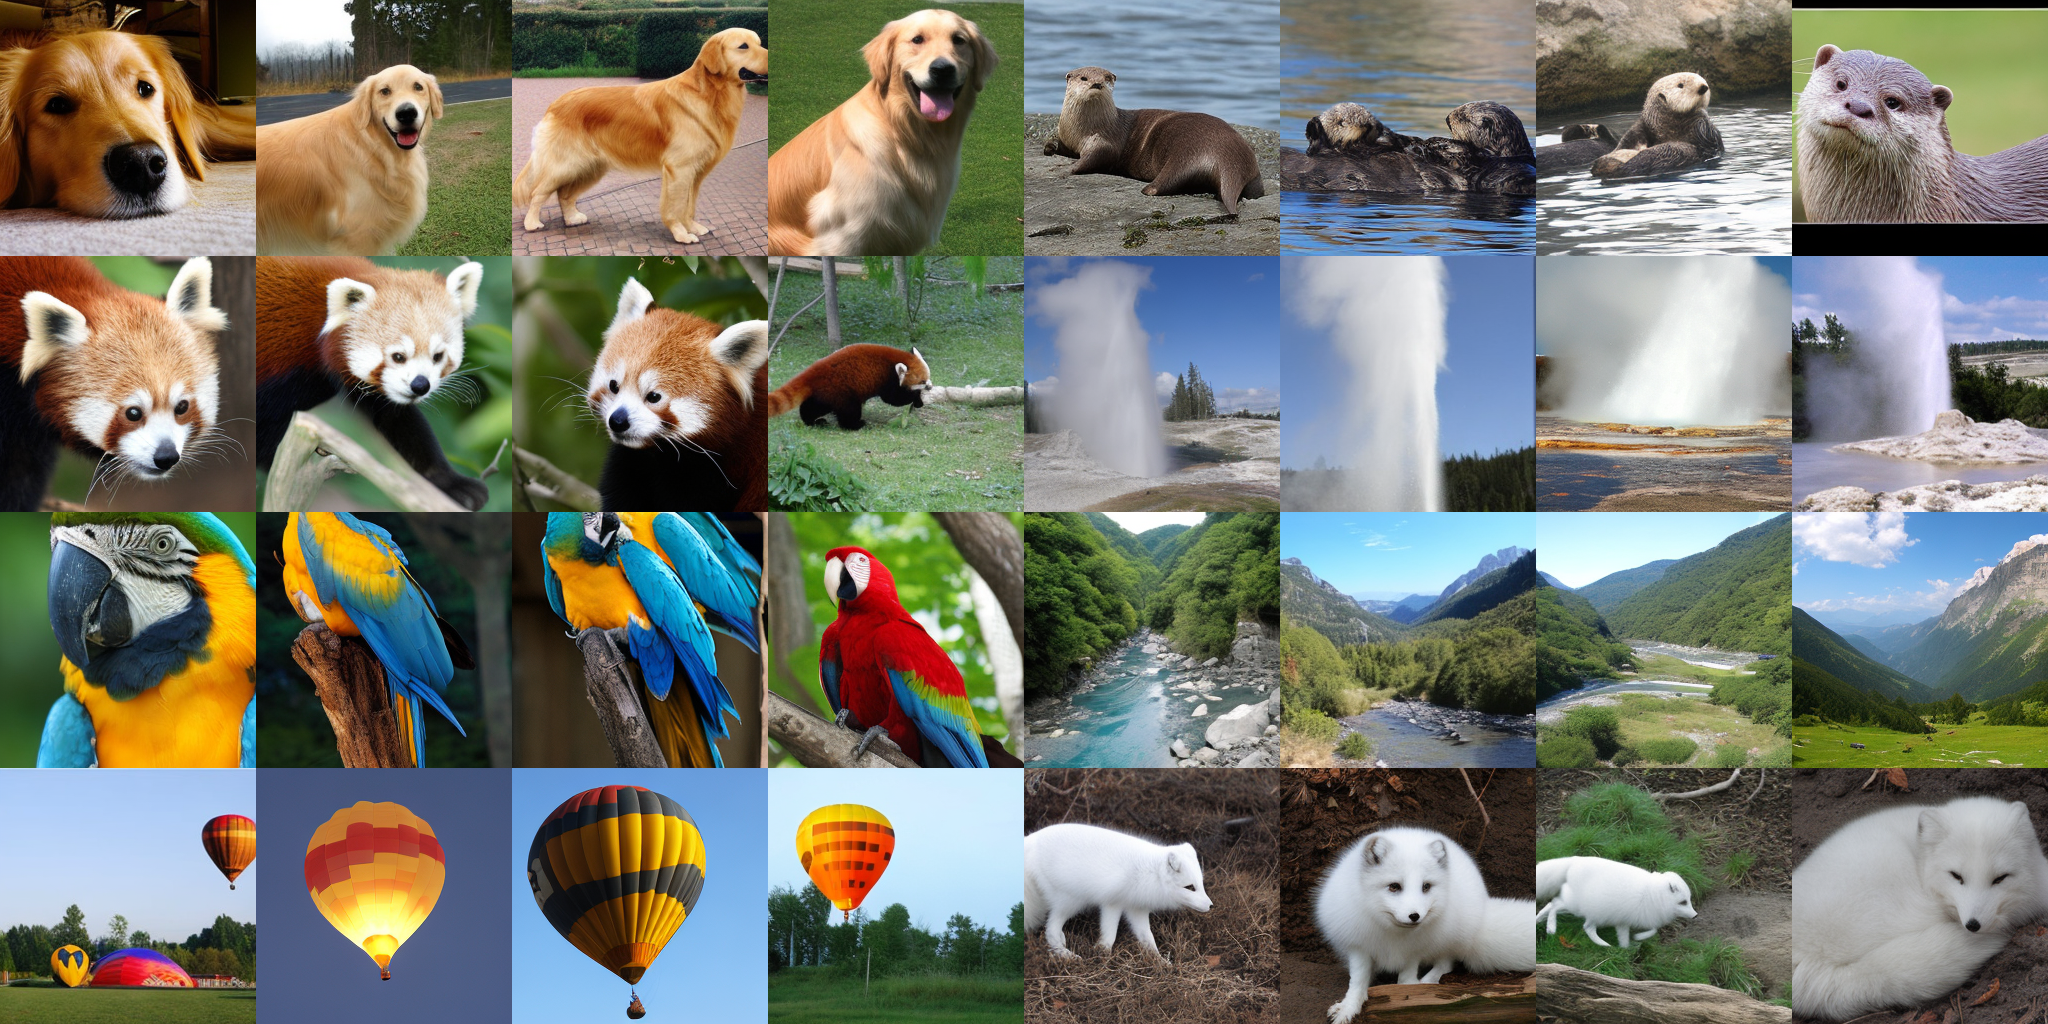

In [8]:
seed = 4321 #@param {type:"number"}
steps = 25 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 3 #@param {type:"slider", min:0, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}
torch.manual_seed(seed)

def stable_diffusion_beta_schedule(linear_start=0.00085, linear_end=0.0120, n_timestep=1000):
    _betas = (
        torch.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timestep, dtype=torch.float64) ** 2
    )
    return _betas.numpy()


_betas = stable_diffusion_beta_schedule()  # set the noise schedule
noise_schedule = NoiseScheduleVP(schedule='discrete', betas=torch.tensor(_betas, device=device).float())


y = torch.tensor(class_labels, device=device)
y = einops.repeat(y, 'B -> (B N)', N=samples_per_row)

def model_fn(x, t_continuous):
    t = t_continuous * len(_betas)
    _cond = nnet(x, t, y=y)
    _uncond = nnet(x, t, y=torch.tensor([1000] * x.size(0), device=device))
    return _cond + cfg_scale * (_cond - _uncond)  # classifier free guidance


z_init = torch.randn(len(y), 4, z_size, z_size, device=device)
dpm_solver = DPM_Solver(model_fn, noise_schedule, predict_x0=True, thresholding=False)

with torch.no_grad():
  with torch.cuda.amp.autocast():  # inference with mixed precision
    z = dpm_solver.sample(z_init, steps=steps, eps=1. / len(_betas), T=1.)
    samples = autoencoder.decode(z)
samples = 0.5 * (samples + 1.)
samples.clamp_(0., 1.)
save_image(samples, "sample.png", nrow=samples_per_row * 2, padding=0)
samples = Image.open("sample.png")
display(samples)